In [1]:
import FinanceDataReader as fdr
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:,.3f}'.format

### 가격 변동성이 크고 거래량이 몰린 종목이 주가가 상승한다.    
"가격 변동성이 크고 거래량이 몰린 종목이 주가가 상승한다" 라는 가설을 증명하기 위해서는 "가격 변동성이 크다", "거래량이 몰린다" 등을 표현하는 변수가 필요합니다. 먼저 일봉데이터를 불러옵니다.

In [2]:
mdl_data = pd.read_pickle('mdl_data.pkl')
mdl_data.head().style.set_table_attributes('style="font-size: 12px"')

첫 번째 종목 060310 (종목이름 3S) 에 대하여 가격 변동성 변수를 만들어 보겠습니다. 전 5일 종가의 평균(price_mean), 전 5일 종가의 표준편차(price_std)를 먼저 구합니다. 그리고, 전 5일의 평균 및 표준편차 대비 당일 종가의 수준을 표준화해서 보여주는 값이 'price_z' 입니다. price_z 값이 -1.96 와 +1.96 안에 값이면 95% 신뢰구간 안에 들어갑니다. 즉 -1.96 보다 작거나, 1.96 보다 크면(100 번중 5번 미만으로 일어날 확율) 당일의 종가는 직전 5일의 움직임에 비해 아주 특별하다고 생각할 수 있습니다.

In [3]:
df = mdl_data[mdl_data['code']=='060310'].copy() # 종목 060310 선택
df['price_mean'] = df['close'].rolling(5).mean() # 직전 5일 종가의 평균
df['price_std'] = df['close'].rolling(5).std() # 직전 5일 종가의 표준편차
df['price_z'] = (df['close'] - df['price_mean'])/df['price_std'] # 직전 5일 종가의 평균 및 표준편차 대비 오늘 종가의 위치
df[['close','price_mean','price_std','price_z']].head(10).style.set_table_attributes('style="font-size: 12px"')

<br> 전 20일로 비교 구간을 바꾸고 전 종목에 대하여 동일한 계산을 합니다. 그리고 그 결과를 data_h1 에 담습니다.

In [5]:
kosdaq_list = pd.read_pickle('kosdaq_list.pkl')

data_h1 = pd.DataFrame()

for code in kosdaq_list['code']:

    data = mdl_data[mdl_data['code']==code].sort_index().copy()
    data['price_mean'] = data['close'].rolling(20).mean() # 전 20일 평균
    data['price_std'] = data['close'].rolling(20).std(ddof=0) # 전 20일 표준편차
    data['price_z'] = (data['close'] - data['price_mean'])/data['price_std']  # 표준화된 Z 값 생성  
    
    data['volume_mean'] = data['volume'].rolling(20).mean() # 전 20일 평균
    data['volume_std'] = data['volume'].rolling(20).std(ddof=0) # 전 20일 표준편차
    data['volume_z'] = (data['volume'] - data['volume_mean'])/data['volume_std']  # 표준화된 Z 값 생성  
       
    data['max_close']  = data[['close_r1','close_r2','close_r3','close_r4','close_r5']].max(axis=1) # 5 영업일 종가 수익율 중 최고 값
    data.dropna(subset=['price_z','volume_z','close_r1','close_r2','close_r3','close_r4','close_r5'], inplace=True) # missing 이 있는 행은 제거  
    
    data = data[(data['price_std']!=0) & (data['volume_std']!=0)] # 0 으로 나누는 상황은 없도록 함.
    
    data_h1 = pd.concat([data, data_h1], axis=0)

data_h1.to_pickle('data_h1.pkl')  

In [4]:
data_h1 = pd.read_pickle('data_h1.pkl')  
print(data_h1['price_z'].agg(['min','max'])) # 최소값과 최대값을 확인함
print(data_h1['volume_z'].agg(['min','max']))

min   -4.359
max    4.359
Name: price_z, dtype: float64
min   -2.568
max    4.359
Name: volume_z, dtype: float64


<br> price_z 에 따른 종가 최고 수익률의 변화를 확인합니다. 최근 20일 종가의 평균 대비 오늘 종가가 낮거나 높은 경우 좋은 수익률을 기대할 수 있습니다.  

<AxesSubplot:xlabel='price_z'>

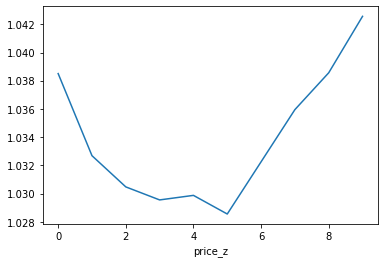

In [5]:
rank = pd.qcut(data_h1['price_z'], q=10, labels=range(10))
data_h1.groupby(rank)['max_close'].mean().plot()

<br>최근 20일 대비 거래량이 많을 수 록 더 좋은 수익률을 기대할 수 있습니다.

<AxesSubplot:xlabel='volume_z'>

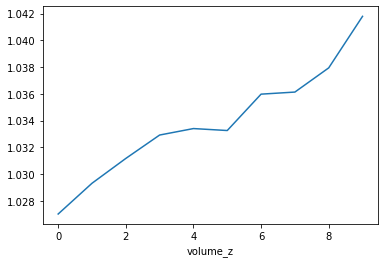

In [6]:
rank = pd.qcut(data_h1['volume_z'], q=10, labels=range(10))
data_h1.groupby(rank)['max_close'].mean().plot()

<br> 종가의 표준화 값 price_z 와 거래량의 표준화 값 volume_z 이 서로 직교하는 테이블로 구성하고 평균 수익율을 보니, 가격이 변동성이 높고, 거래량이 몰리는 종목은 평균 수익율이 더 높다는 것이 확인되었습니다.

In [7]:
rank1  = pd.qcut(data_h1['price_z'], q=5, labels=range(5))
rank2  = pd.qcut(data_h1['volume_z'], q=5, labels=range(5))

data_h1.groupby([rank1, rank2])['max_close'].mean().unstack().style.set_table_attributes('style="font-size: 12px"')